## Uncertainty Experiments
Using the sampling results from the experiments.ipynb file, this file will be used to determine the uncertainty of a predictive model on the same dataset (MNIST dataset).

The purpose of a generative model is to learn an encoding and decoding function that goes from an observation space to a latent space and back. To do so, a prior function is specified for the probability distribution of the latent space (most often this is a Gaussian prior). Using this prior, a posterior distribution for the observation space can be conditioned on this latent space, in turn allowing for a decoder function to be created. 

One of the major hypotheses and assumptions for generative models is that there exists some manifold for which the data we are modelling will exist. Furthermore, this manifold is of a lower dimension and is embedded in the observation space. Put more simply, there exists a sort of blanket for all the dimensions for all the pixels in an image (for example) where data points have semantic meaning. A compelling argument for this hypothesis is the fact that if you produce randomly generated black and white images in hopes of getting a number, you most likely will not; this is because there only exists a handful of combinations of these pixels that correspond to handwritten digits.

This manifold view is important for the experiments about to proceed. A whole new are of research aims at understanding the geometry of the manifold generated from the decoder of a generative model. Since deterministic models produce smooth function approximations, the manifold produced by the image of the decoder will also be smooth. In other words, there will not be an discontinuities, as there might be in the true data manifold. Therefore, some research points to the importance of random manifolds, which have uncertainty in the decoder as well and helps reintegrate these discontinuities.

TODO:
1. Go through the test set now. Take 5 examples of a correct prediction and determine the certainty by sampling using the chosen sampling technique, then checking the variance in the output.
2. Take 5 examples of incorrect prediction and check this uncertainty.
3. Use the distance from trainset centers for each class as measure of uncertainty.
4. Check against rbf "baseline".
5. Check the volume around M(z) for uncertainty as well

## Data Setup

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from models.vae import VariationalAutoencoder

device = torch.device("cpu")

hidden_dim = 2
model = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load("./pretrained_models/manifold_vae.pth", map_location=device, weights_only=True))



transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ]
    )


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

print(f"Using device: {device}")


x_train, y_train = next(iter(train_loader))
x_train = x_train[:1]
y_train = y_train[:1]

x_test, y_test = next(iter(test_loader))

from collections import defaultdict

vals = defaultdict(list)

model.eval()
with torch.no_grad():
    for x, y in train_loader:
        _, z, _, _ = model(x)
        for i in range(len(y)):
            y_val = y[i].item()
            vals[y_val].append(z[i])

# Retrieving discriminative prediction model
from models.cnn import CustomCNN

cnn = CustomCNN(1, 10)
cnn.load_state_dict(torch.load("pretrained_models/CNN.pth"))

# Retrieving one correct prediction and one misprediction
correct = None
incorrect = None
for img, label in test_loader:
    pred = cnn.predict(img)
    if pred == label and correct is None:
        correct = (img, pred)
    elif pred != label and incorrect is None:
        incorrect = (img, pred)
        # plt.imshow(img.reshape((28, 28, 1)))
        # print(pred)
    
    if correct is not None and incorrect is not None:
        break



Using device: cpu


In [15]:
correct_list = []
incorrect_list = []
for img, label in test_loader:
    pred = cnn.predict(img)
    if pred == label:
        correct_list.append((img, pred))
    elif pred != label:
        incorrect_list.append((img, pred))

## Uncertainty assessed using Geodesic Sampling

Given an input data and a prediction from a discriminative model, I believe it should be possible to determine the uncertainty of the model by sampling points near the input data and determining the variance of the predictions on these samples. Due to the non-linear decoder, drawing Gaussian samples near the encoded input (i.e. in the latent space) will not necessarily correspond to drawing samples that are close on the manifold. In other words, the measure of distance on the manifold is not Euclidean as it is in the latent space. Moreover, these Gaussian samples may produce data that is no longer on the manifold. 

To increase the chances of sampling semantically similar observations given an input and staying on the manifold, samples will be taken along a geodesic between the input and training points for the given prediction. The hope is that if the prediction is incorrect, then the points along the geodesic will be variable leading to different predictions in the discriminative model. Furthermore, the samples will hopefully "make sense" since they are more likely to exist on the true manifold

Curve 0 has geodesic length: 1.7920968532562256
Curve 1 has geodesic length: 1.6398940086364746
Curve 2 has geodesic length: 1.5732661485671997
Curve 3 has geodesic length: 2.090951919555664
Curve 4 has geodesic length: 2.525068998336792
Curve 5 has geodesic length: 1.905106544494629
Curve 6 has geodesic length: 1.8746715784072876
Curve 7 has geodesic length: 0.5709299445152283
Curve 8 has geodesic length: 1.1364154815673828
Curve 9 has geodesic length: 1.7932192087173462


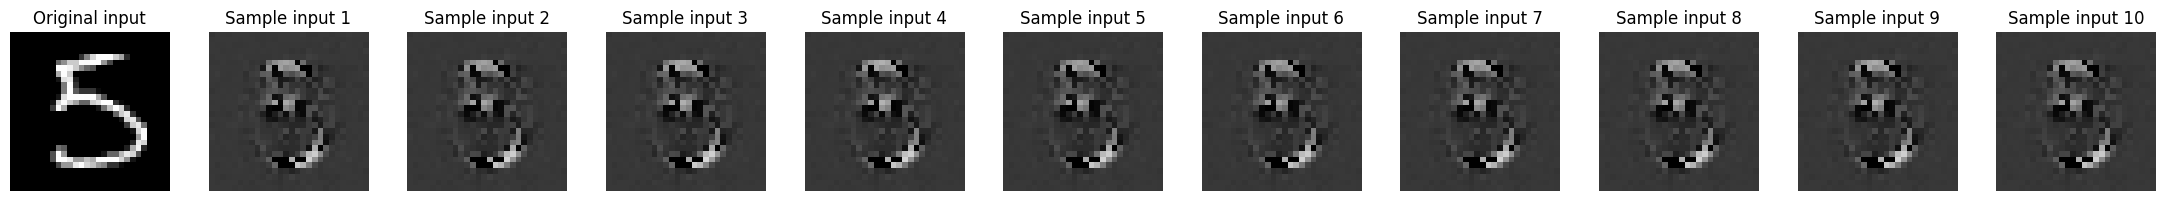

[0.8536999 0.8536999 0.8536999 1.2879107 0.8536999 1.8824902 0.8536999
 0.8536999 0.8536999 0.8536999]
Prediction on samples: [5, 5, 3, 3, 5, 5, 5, 5, 3, 5]
Variance of prediction: 0.8400000000000001
Entropy of prediction: 2.2589404582977295
Entropy as percent: 98.1%


In [17]:
from utils.sampling import geodesic_sampling_close
from utils.visualize import visualize_samples
from utils.uncertainty import geodesic_uncertainty

samples = geodesic_sampling_close(model, vals, incorrect[0], incorrect[1], torch.device("cpu"), num_samples=10)
visualize_samples(incorrect[0], samples)
preds, var, entropy, entropy_uncertainty = geodesic_uncertainty(cnn, samples)

print(f"Prediction on samples: {preds}")
print(f"Variance of prediction: {var}")
print(f"Entropy of prediction: {entropy}")
print(f"Entropy as percent: {(entropy_uncertainty * 100).round(1)}%")

Curve 0 has geodesic length: 1.9699610471725464
Curve 1 has geodesic length: 1.8275219202041626
Curve 2 has geodesic length: 1.5822776556015015
Curve 3 has geodesic length: 2.1422336101531982
Curve 4 has geodesic length: 2.637190341949463


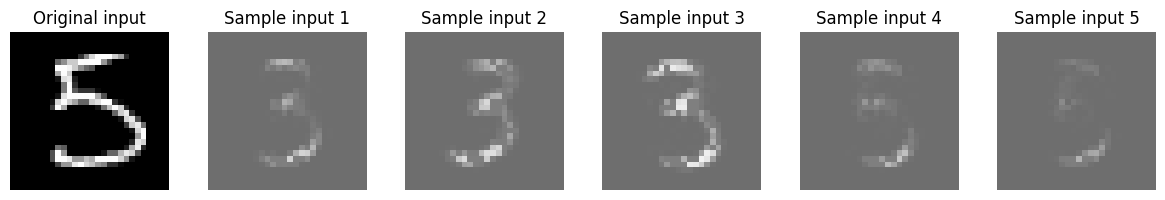

[0.42668372 0.42668372 0.42668372 1.1598465  0.42668372 0.42668372
 0.42668372 0.42668372 0.42668372 0.42668372]
Prediction on samples: [3, 3, 3, 3, 3]
Variance of prediction: 0.0
Entropy of prediction: 2.2291808128356934
Entropy as percent: 96.8%


In [9]:
from utils.sampling import geodesic_sampling_whole
from utils.visualize import visualize_samples
from utils.uncertainty import geodesic_uncertainty

samples = geodesic_sampling_whole(model, vals, incorrect[0], incorrect[1], torch.device("cpu"), num_samples=5)
visualize_samples(incorrect[0], samples)
preds, var, entropy, entropy_uncertainty = geodesic_uncertainty(cnn, samples)

print(f"Prediction on samples: {preds}")
print(f"Variance of prediction: {var}")
print(f"Entropy of prediction: {entropy}")
print(f"Entropy as percent: {(entropy_uncertainty * 100).round(1)}%")

## Uncertainty assessed using Average Intraclass Geodesic Lengths

Another attempt at quantifying uncertainty comes from the geodesic lengths between the input on the manifold and the predicted class. An assumption for this uncertainty to make sense is that similar classes exist close on the true manifold and dissimilar classes are farther. In other words, the hope is for little overlap, low intraclass distances, and higher interclass distances. If this assumption holds true, then the average geodesic distance between the input and the samples from the predicted class should be similar to the intraclass distance of the predicted class. Moreover, the geodesic length between the input and the non-predicted classes is hopefully higher, indicating a higher certainty that the input does not belong to those classes.

## Uncertainty using the Volume Riemannian Metric of the Manifold

Geodesics are created through the observation that infinitisimal steps along the manifold are Euclidean in nature. This observation is similar to how walking on Earth seems flat to humans despite the curved surface. Moreover, these small steps allow us to calculate the tangent of a point on the manifold, creating a tangent space and geodesics.

However, geodesics are not the only interesting measure we can calculate on the manifold. We can also integrate over a small area on the manifold to get a volume measure. This volume measure equates to certainty on our manifold. (Look at this paper again.)

### Testing with the deterministic manifolds created using the Simple VAE

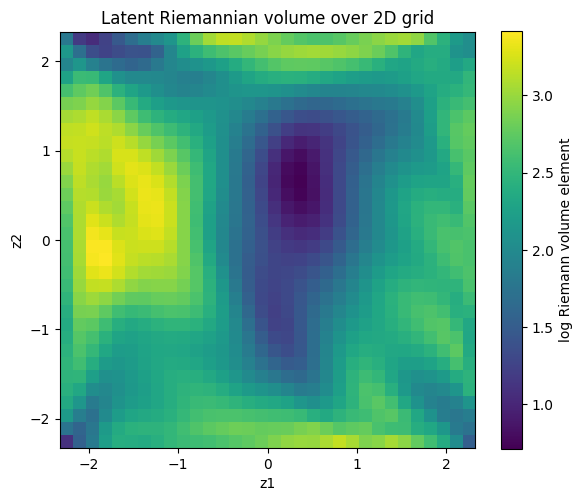

In [6]:
from utils.visualize import visualize_latent_uncertainty_grid

device = torch.device("cpu")
visualize_latent_uncertainty_grid(model, device, n_steps=32)


In [8]:
from utils.riemann import log_riemann_volume

def retrieve_G_volumes(model, input_list):
    values = []
    for val in input_list:
        model.eval()
        with torch.no_grad():
            z1, _ = model.encoder(val[0])
            values.append(log_riemann_volume(model.decoder, z1).item())
    return values

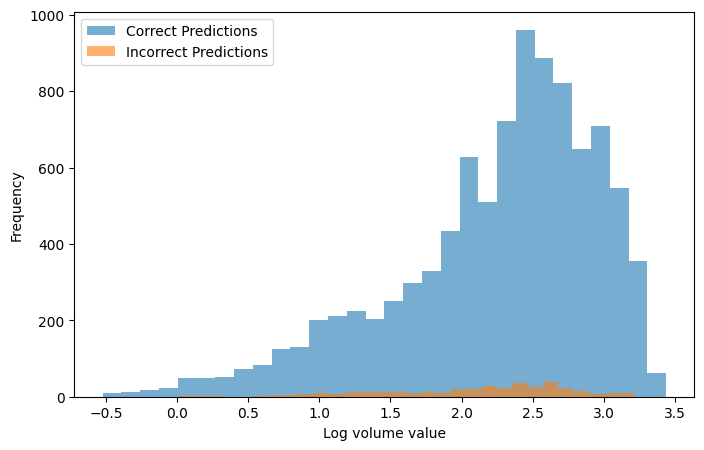

In [ ]:
import matplotlib.pyplot as plt

incorrect_G_volumes = retrieve_G_volumes(model, incorrect_list)
correct_G_volumes = retrieve_G_volumes(model, correct_list)

plt.figure(figsize=(8,5))
plt.hist(correct_G_volumes, bins=30, alpha=0.6, label="Correct Predictions")
plt.hist(incorrect_G_volumes, bins=30, alpha=0.6, label="Incorrect Predictions")
plt.xlabel("Log volume value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Per-class Volume Uncertainty

In [10]:
def retrieve_G_volumes(model, z_list):
    values = []
    for z in z_list:
        model.eval()
        with torch.no_grad():
            values.append(log_riemann_volume(model.decoder, z.unsqueeze(0)).item())
    return values

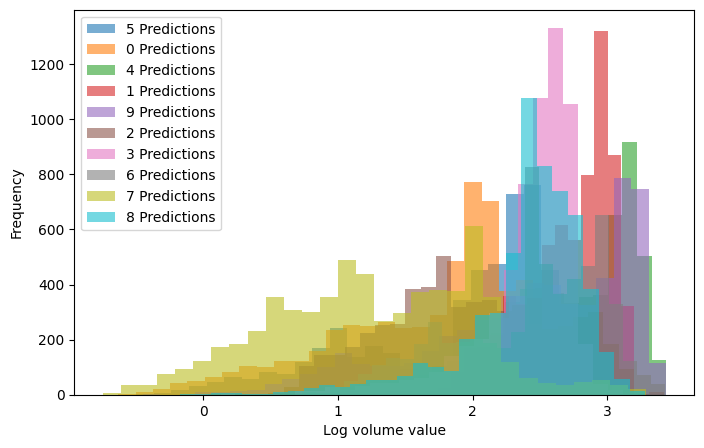

In [ ]:
volume_vals = {}
for mnist_class in vals.keys():
    z_vals = vals[mnist_class]
    volume_vals[mnist_class] = retrieve_G_volumes(model, z_vals)


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for mnist_class in volume_vals.keys():
    plt.hist(volume_vals[mnist_class], bins=30, alpha=0.6, label=f"{mnist_class} Predictions")
plt.xlabel("Log volume value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


There seems to be a smaller volume on the manifold around the 7-digit class. The log volume using the Riemannian metric essentially quantifies the sharpness of the curvature around a given point. The sharper the curve is, the higher the volume. Furthermore, it also means that small changes in the latent space equates to large jumps on the manifold and hence an instability. On the other hand, smaller volumes means that the curve is smoother here and that the autoencoder is more stable around these latent points when decoded.

If we look at the training grid visualization, the reconstruction of the 7 values is quite clear and distinct from the other values. Other values such as 4 and 5 struggle in some cases to be reconstructed and this instability may be reflected in the high volume seen above.


In other words, this volume metric may be useful in understanding better which classes are generally more difficult to isolate from one another and therefore generally lead to higher uncertainty in a model.

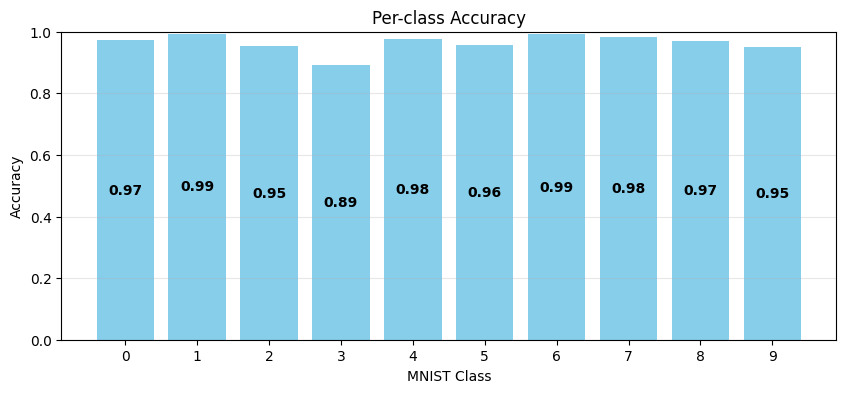

In [37]:
import matplotlib.pyplot as plt
from collections import defaultdict

correct_count = defaultdict(int)
incorrect_count = defaultdict(int)

for val in correct_list:
    correct_count[val[1]] += 1
for val in incorrect_list:
    incorrect_count[val[1]] += 1

num_classes = 10
class_accuracy = []
for i in range(num_classes):
    total = correct_count[i] + incorrect_count[i]
    class_accuracy.append(correct_count[i]/total)


plt.figure(figsize=(10,4))
plt.bar(range(num_classes), class_accuracy, color='skyblue')
plt.xticks(range(num_classes))
plt.xlabel("MNIST Class")
plt.ylabel("Accuracy")
plt.title("Per-class Accuracy")
plt.ylim(0,1)
plt.grid(axis='y', alpha=0.3)

# Help from ChatGPT with visualization code below
for i, acc in enumerate(class_accuracy):
    plt.text(
        i,                  
        acc / 2,            
        f"{acc:.2f}",       
        ha='center',        
        va='center',        
        color='black',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

Despite the indication of higher curvature around the 4-digit than for example the 7-digit, the discriminative model performs equally well. It is difficult to draw any conclusions from this alone. However, it is interesting to ponder the reason.

One reason for this result may be that the discriminative model is signficantly better at learning and differentiating the features. Therefore, the manifold created by the VAE is not representative enough of the true manifold. Furthermore, the smoothness of the generated determinsitic manifold may be warping some important information surrounding the certainty. 

### Testing using Manifold from IRVAE

In [5]:
from models.irvae import IRVAE

hidden_dim = 2
irvae = IRVAE([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28]).to(device)
irvae.load_state_dict(torch.load("./pretrained_models/irvae.pth", map_location=device, weights_only=True))

<All keys matched successfully>

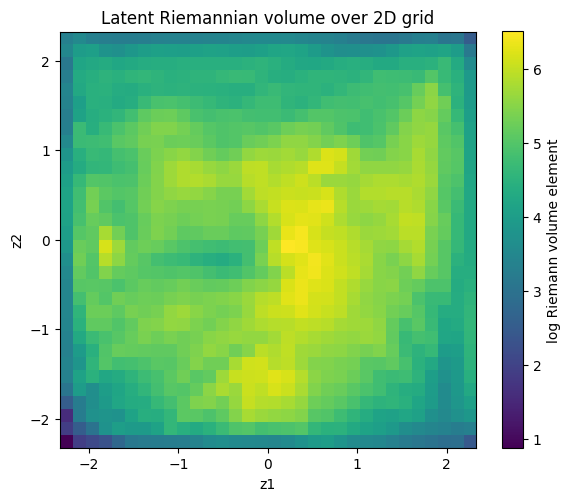

In [6]:
from utils.visualize import visualize_latent_uncertainty_grid

device = torch.device("cpu")
visualize_latent_uncertainty_grid(irvae, device, n_steps=32)

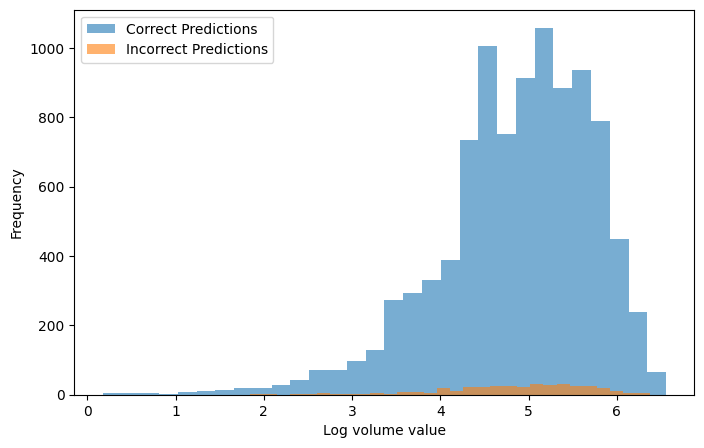

In [9]:
incorrect_G_volumes = retrieve_G_volumes(irvae, incorrect_list)
correct_G_volumes = retrieve_G_volumes(irvae, correct_list)

plt.figure(figsize=(8,5))
plt.hist(correct_G_volumes, bins=30, alpha=0.6, label="Correct Predictions")
plt.hist(incorrect_G_volumes, bins=30, alpha=0.6, label="Incorrect Predictions")
plt.xlabel("Log volume value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

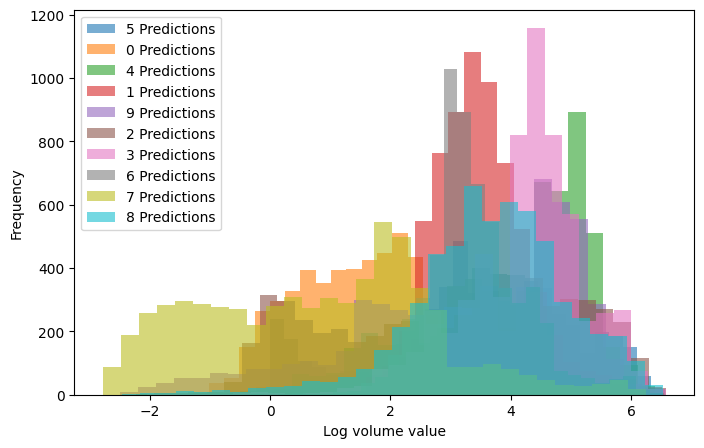

In [11]:
volume_vals = {}
for mnist_class in vals.keys():
    z_vals = vals[mnist_class]
    volume_vals[mnist_class] = retrieve_G_volumes(irvae, z_vals)


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for mnist_class in volume_vals.keys():
    plt.hist(volume_vals[mnist_class], bins=30, alpha=0.6, label=f"{mnist_class} Predictions")
plt.xlabel("Log volume value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Interestingly, the IRVAE results in a more stable volume but also higher. Still, for some of classes such as 7 and 0, the volumes are significantly lower.

### Testing using the Random manifolds created using Simple VAE + RBFNet
For the random manifolds, the Riemannian metric is defined as the sum of the Riemannian metric for the mean Jacobian and the variance Jacobian.

In [3]:
from models.rbf import RBFNet

z_train_np = torch.load("pretrained_models/z_train.pt")
num_clusters = 16
a = 0.85

rbf = RBFNet(z_train_np, output_dim=28*28, K=num_clusters, a=a)
rbf.load_state_dict(torch.load("pretrained_models/RBF.pth"))

<All keys matched successfully>

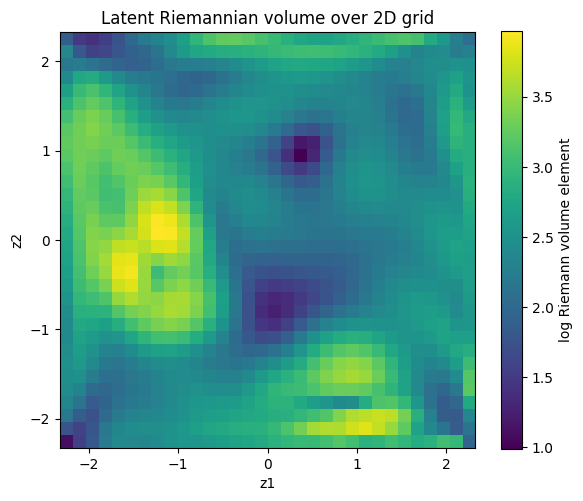

In [ ]:
from utils.visualize import visualize_latent_uncertainty_grid_random

device = torch.device("cpu")
visualize_latent_uncertainty_grid_random(model.decoder, rbf, device, n_steps=32)

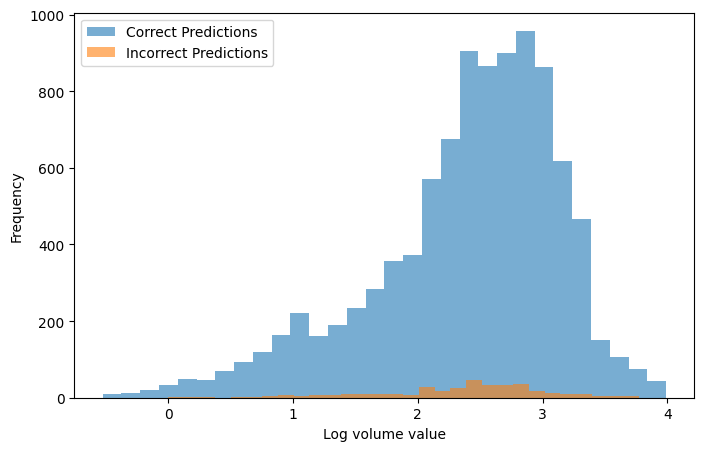

In [7]:
from utils.riemann import log_random_riemann_volume

def retrieve_G_volumes(mu_decoder, var_decoder, input_list):
    values = []
    for val in input_list:
        mu_decoder.eval()
        var_decoder.eval()
        with torch.no_grad():
            z1, _ = model.encoder(val[0])
            values.append(log_random_riemann_volume(mu_decoder, var_decoder, z1).item())
    return values

incorrect_G_volumes = retrieve_G_volumes(model.decoder, rbf, incorrect_list)
correct_G_volumes = retrieve_G_volumes(model.decoder, rbf, correct_list)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(correct_G_volumes, bins=30, alpha=0.6, label="Correct Predictions")
plt.hist(incorrect_G_volumes, bins=30, alpha=0.6, label="Incorrect Predictions")
plt.xlabel("Log volume value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Per-class Volume Uncertainty

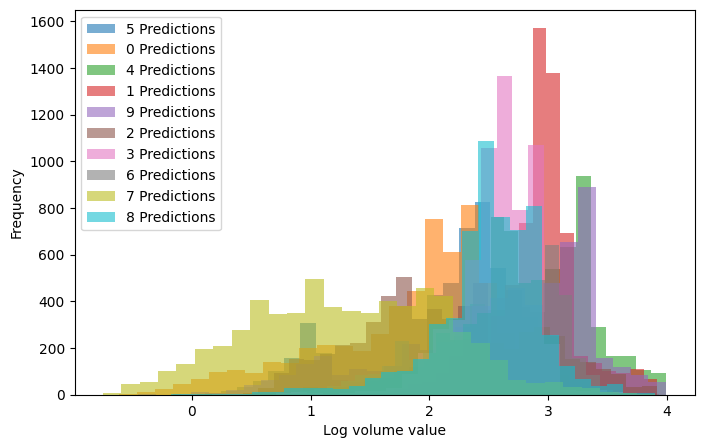

In [8]:
def retrieve_G_volumes(mu_decoder, var_decoder, z_list):
    values = []
    for z in z_list:
        mu_decoder.eval()
        var_decoder.eval()
        with torch.no_grad():
            values.append(log_random_riemann_volume(mu_decoder, var_decoder, z.unsqueeze(0)).item())
    return values

volume_vals = {}
for mnist_class in vals.keys():
    z_vals = vals[mnist_class]
    volume_vals[mnist_class] = retrieve_G_volumes(model.decoder, rbf, z_vals)


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for mnist_class in volume_vals.keys():
    plt.hist(volume_vals[mnist_class], bins=30, alpha=0.6, label=f"{mnist_class} Predictions")
plt.xlabel("Log volume value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


I do not observe any significant changes in the volumes found when comparing the determinsitic vs. random Riemannian manifold. Perhaps the random manifold has slightly more variability in the volumes for each class.